In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import json
from PIL import Image
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, BlipForQuestionAnswering
from tqdm.notebook import tqdm
from collections import Counter
from sklearnex import patch_sklearn
from sklearn.metrics import f1_score
patch_sklearn(['KMeans',
            'DBSCAN'])
from sklearn.cluster import DBSCAN,KMeans
os.chdir("/root/TAC/")
DATA_PREFIX = "/root/TAC/data/rgbd_data/pretrain_val"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Room type classification

before this cell, run `python run_dist.py --mode generate_eval_order --config config/bottlenecks/vit_base.yaml DATA.RGBD.EVAL.shuffle shuffle` to generate file paths.

Get BLIP labelling for all samples

In [7]:
# 
with open("eval_rgb_order.json","r") as f:
    rgb_files = json.loads(f.read())
with open("eval_depth_order.json","r") as f:
    depth_files = json.loads(f.read())
rgb_files = [os.path.join(DATA_PREFIX, v) for v in rgb_files]
depth_files = [os.path.join(DATA_PREFIX, v) for v in depth_files]
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to("cuda")
labels = []
batch_size = 64
N = len(rgb_files)
for i in tqdm(range(0,N,batch_size)):
    start = i
    stop = min(N, i+batch_size)
    prompt = ["What is the room type?"]*(stop-start)
    img = [Image.open(v) for v in rgb_files[start:stop]]
    inputs = blip_processor(img, prompt, return_tensors="pt").to("cuda")
    out = blip_model.generate(**inputs)
    labels.extend(blip_processor.batch_decode(out, skip_special_tokens=True))
raw_data = {
    "rgb_files":rgb_files,
    "depth_files":depth_files,
    "labels":labels,
}
with open("room_type_raw.json","w") as f:
    f.write(json.dumps(raw_data, indent=2))

  0%|          | 0/7765 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [2]:
with open("room_type_raw.json","r") as f:
    data = json.loads(f.read())
rgb_files = data["rgb_files"]
depth_files = data["depth_files"]
labels = data["labels"]
top_num = 20
cnt = Counter(labels)
label_set = [v[0] for v in cnt.most_common(top_num)]
cnt.most_common(top_num)

[('bathroom', 136816),
 ('bedroom', 89550),
 ('living room', 75978),
 ('kitchen', 53030),
 ('office', 51343),
 ('hallway', 16818),
 ('hotel room', 15711),
 ('dining room', 10875),
 ('classroom', 6502),
 ('playroom', 5988),
 ('conference room', 4717),
 ('break room', 3120),
 ('hotel', 2142),
 ('attic', 1967),
 ('basement', 1865),
 ('storage', 1826),
 ('hospital room', 1254),
 ('garage', 1223),
 ('waiting room', 1123),
 ('patio', 1041)]

Get TAC embeddings for all samples

In [3]:
filter_rgb_files = []
filter_depth_files = []
filter_labels = []
for i in range(len(rgb_files)):
    if labels[i] in label_set:
        filter_rgb_files.append(rgb_files[i])
        filter_depth_files.append(depth_files[i])
        filter_labels.append(labels[i])

In [92]:

data = {
    "filter_rgb_files": filter_rgb_files,
    "filter_depth_files": filter_depth_files,
    "filter_labels": filter_labels,
}
with open("room_type_filter.json","w") as f:
    f.write(json.dumps(data, indent=2))


In [4]:
with open("room_type_filter.json","r") as f:
    data = json.loads(f.read())
filter_rgb_files = data["filter_rgb_files"]
filter_depth_files = data["filter_depth_files"]
filter_labels = data["filter_labels"]

In [12]:
import imports
from config.default import get_config
from common.registry import registry

config = get_config("config/v2/v2_tac.yaml")

model_cls = registry.get_model(config.MODEL.name)
model = model_cls.from_config(config)
ckpt = torch.load("/root/TAC/data/checkpoints/tacv2_tacnice/ckpt.TAC.00.pth")
model.load_state_dict(ckpt["state_dict"])
loader_cls = registry.get_dataloader(config.TRAINER.loaders[0])
loader = loader_cls(
    config,
    mode="eval"
)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.7.self_attn.q_proj.bias', 'text_model.encoder.layers.8.mlp.fc2.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.2.self_attn.q_proj.bias', 'text_model.encoder.layers.2.mlp.fc2.weight', 'text_model.encoder.layers.9.layer_norm2.weight', 'text_model.encoder.layers.2.self_attn.v_proj.bias', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.4.mlp.fc1.bias', 'text_model.encoder.layers.11.self_attn.v_proj.bias', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.5.mlp.fc1.weight', 'text_model.encoder.layers.2.layer_norm2.weight', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.layers.9.mlp.fc1.weight', 'text_model.encoder.layers.9.layer_norm1.weight', 'text_model.encoder.layers.4.self_attn.out_proj.weight', 'text_model.encoder.layers.2.mlp

In [13]:
import torch
import torch.nn.functional as F
device = torch.device("cuda")
model.to(device)
model.eval()
K = len(filter_rgb_files)
batch_size = 128
all_rgb_embeddings = []
all_depth_embeddings = []
for i in tqdm(range(0,K,batch_size)):
    image_batch = []
    depth_batch = []
    label_batch = []
    for j in range(i, min(i+batch_size, K)):
        image = loader.dataset.read_image(filter_rgb_files[j])
        if "hm3d" in filter_rgb_files[j]:
            scale = 1000.0
        elif "sun3d" in filter_rgb_files[j]:
            scale = 8000.0
        elif "scenenet" in filter_rgb_files[j]:
            scale = 1000.0
        elif "diode" in filter_rgb_files[j]:
            scale = 1000.0
        elif "tum" in filter_rgb_files[j]:
            scale = 5000.0
        depth = loader.dataset.read_depth(filter_depth_files[j], depth_scale=scale)
        image_batch.append(image)
        depth_batch.append(depth)
    with torch.no_grad():
        image_batch = torch.stack(image_batch).to(device)
        depth_batch = torch.stack(depth_batch).to(device)
        image_embeddings = F.normalize(model.embed_image(image_batch)).cpu()
        depth_embeddings = F.normalize(model.embed_depth(depth_batch)).cpu()
    all_rgb_embeddings.extend(list(image_embeddings))
    all_depth_embeddings.extend(list(depth_embeddings))
all_rgb_embeddings = np.stack([v.numpy() for v in all_rgb_embeddings])
all_depth_embeddings = np.stack([v.numpy() for v in all_depth_embeddings])
np.save("all_rgb_embeddings_nice.npy", all_rgb_embeddings)
np.save("all_depth_embeddings_nice.npy", all_depth_embeddings)

  0%|          | 0/3773 [00:00<?, ?it/s]

Zero-shot room type classification

In [12]:
def predict(feat, centers):
    res = None
    mindist = 0x7f7f7f7f
    for k,v in centers.items():
        b = len(v)
        x = np.expand_dims(feat, axis=0).repeat(b,axis=0)
        dist = np.linalg.norm(x-v, axis=1)
        if dist.min()<mindist:
            mindist = dist.min()
            res = k
    return res
def evaluate(predictions, labels, label_set):
    acc_split = {v:0 for v in label_set}
    total_split = {v:0 for v in label_set}
    f1 = f1_score(labels, predictions, average="macro")
    N = len(predictions)
    C = 0
    for i in range(N):
        total_split[labels[i]]+=1
        if predictions[i]==labels[i]:
            C += 1
            acc_split[labels[i]]+=1
    for v in label_set:
        acc_split[v] = acc_split[v]/total_split[v]
    return {
        "acc": C/N,
        "acc_split": acc_split,
        "f1": f1
    }
def exp(train_portion=0.6, key_type="rgb",return_pred=False):
    # read embeddings
    all_rgb_embeddings = np.load("all_rgb_embeddings_nice.npy")
    all_depth_embeddings = np.load("all_depth_embeddings_nice.npy")
    with open("room_type_filter.json","r") as f:
        data = json.loads(f.read())
    filter_labels = data["filter_labels"]

    train_num = int(len(filter_labels)*train_portion)
    train_labels = filter_labels[:train_num]
    train_rgb_embeddings = all_rgb_embeddings[:train_num]
    train_depth_embeddings = all_depth_embeddings[:train_num]
    val_labels = filter_labels[train_num:]
    val_rgb_embeddings = all_rgb_embeddings[train_num:]
    val_depth_embeddings = all_depth_embeddings[train_num:]

    # get centers
    label_set = list(set(filter_labels))
    rgb_feat = {v:[] for v in label_set}
    depth_feat = {v:[] for v in label_set}
    rgb_idx = {v:[] for v in label_set}
    depth_idx = {v:[] for v in label_set}
    for i,lb in enumerate(train_labels):
        rgb_idx[lb].append(i)
        depth_idx[lb].append(i)
    for k in rgb_feat.keys():
        rgb_feat[k] = train_rgb_embeddings[np.array(rgb_idx[k])]
        depth_feat[k] = train_depth_embeddings[np.array(depth_idx[k])]

    rgb_centers = {v:[] for v in label_set}
    depth_centers = {v:[] for v in label_set}
    for lb in label_set:
        n_cluster = min(256, max(16, len(rgb_feat[lb])//200))
        db = KMeans(n_clusters=n_cluster, init="k-means++", n_init="auto").fit(rgb_feat[lb])
        rgb_centers[lb] = db.cluster_centers_

        db = KMeans(n_clusters=n_cluster, init="k-means++", n_init="auto").fit(depth_feat[lb])
        depth_centers[lb] = db.cluster_centers_
    
    # calculate accuracy
    centers = rgb_centers
    if key_type=="depth":
        centers = depth_centers
    predictions = []
    for i in range(len(val_depth_embeddings)):
        res = predict(val_depth_embeddings[i], centers)
        predictions.append(res)
    res = evaluate(predictions, val_labels,label_set)
    if return_pred:
        return res, predictions,val_labels,data["filter_rgb_files"][train_num:],data["filter_depth_files"][train_num:]
    else:
        return res

In [15]:
results = {
    "rgb":{
        0.1:{}, 0.2:{}, 0.3:{}, 0.4:{}, 0.5:{}, 0.6:{}, 0.7:{}, 0.8:{}, 0.9:{}
    },
    "depth":{
        0.1:{}, 0.2:{}, 0.3:{}, 0.4:{}, 0.5:{}, 0.6:{}, 0.7:{}, 0.8:{}, 0.9:{}
    }
}
for train_portion in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for key_type in ["rgb","depth"]:
        print(key_type, train_portion)
        results[key_type][train_portion] = exp(train_portion=train_portion, key_type=key_type)

rgb 0.1
depth 0.1
rgb 0.2
depth 0.2
rgb 0.3
depth 0.3
rgb 0.4
depth 0.4
rgb 0.5
depth 0.5
rgb 0.6
depth 0.6
rgb 0.7
depth 0.7
rgb 0.8
depth 0.8
rgb 0.9
depth 0.9


Visualization

In [16]:
acc_split = results["rgb"][0.8]["acc_split"]
acc_split = {k: v for k, v in sorted(acc_split.items(), key=lambda item: item[1], reverse=True)}
acc = results["rgb"][0.8]["acc"]

/tmp/ipykernel_906886/1178056727.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha="right")


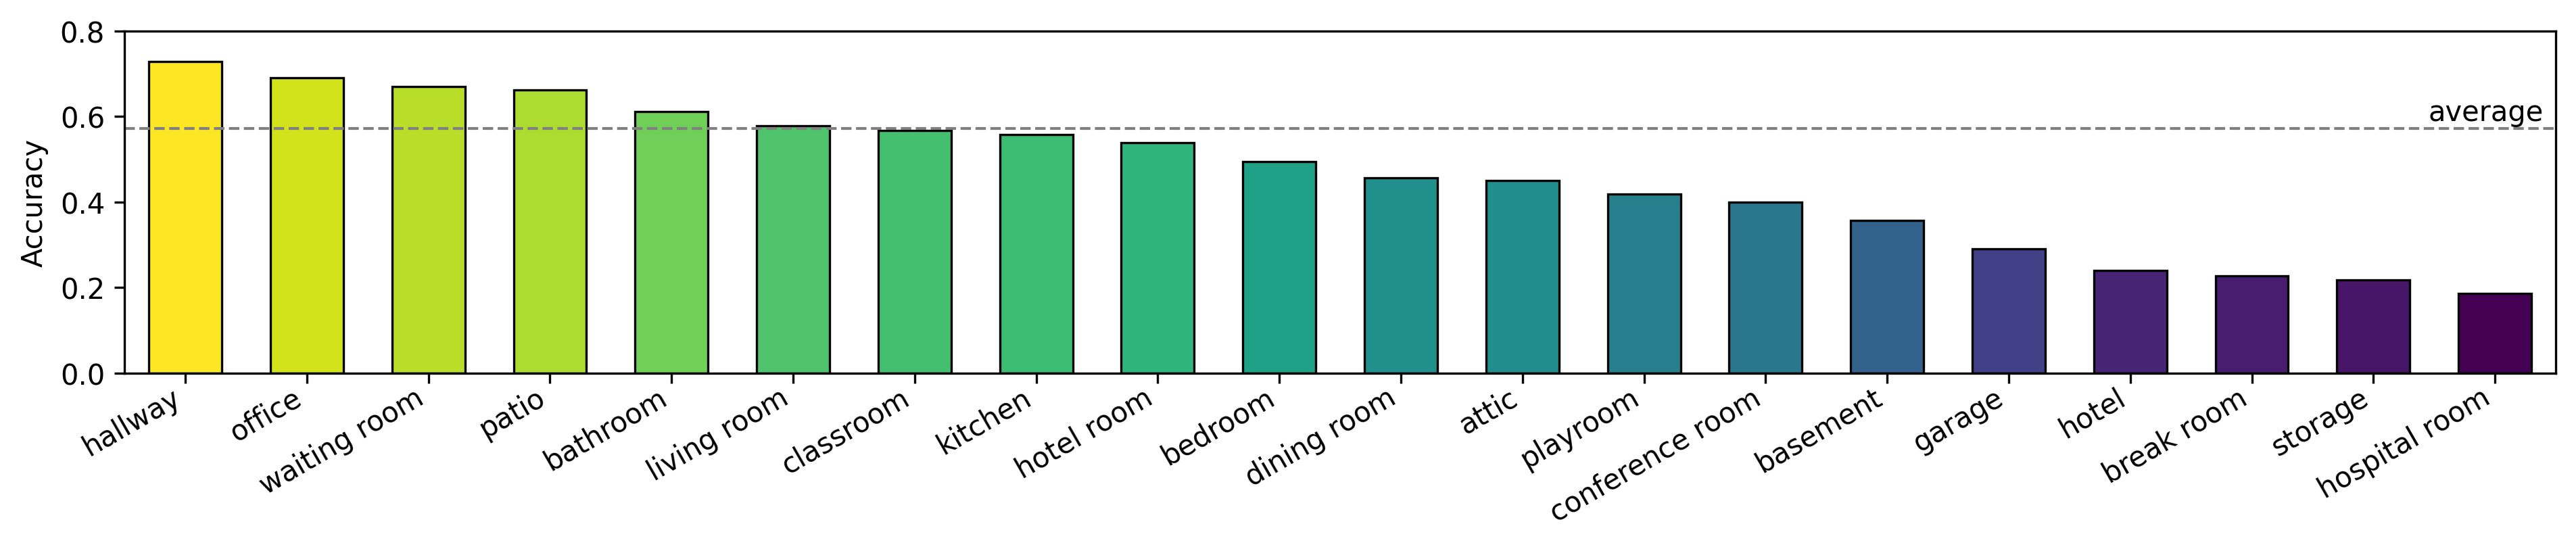

In [17]:
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
fig = plt.figure(figsize=(12.8,2.8), dpi=300)
plt.axhline(y=acc, color='gray', linestyle='--',linewidth=1)
plt.text(19.4,acc+0.02,"average",ha="right")
plt.bar(acc_split.keys(), acc_split.values(), width=0.6, linewidth=0.8, edgecolor="black", color=cm.viridis(rescale(np.array(list(acc_split.values())))))
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha="right")
ax.tick_params(axis='x', which='major', pad=0)
plt.ylabel("Accuracy")
# plt.title("Room Classfication Accuracy for Different Rooms")
plt.xlim(-0.5,19.5)
plt.ylim(0,0.8)
plt.tight_layout()
plt.savefig("room_split.pdf", bbox_inches='tight')
plt.show()

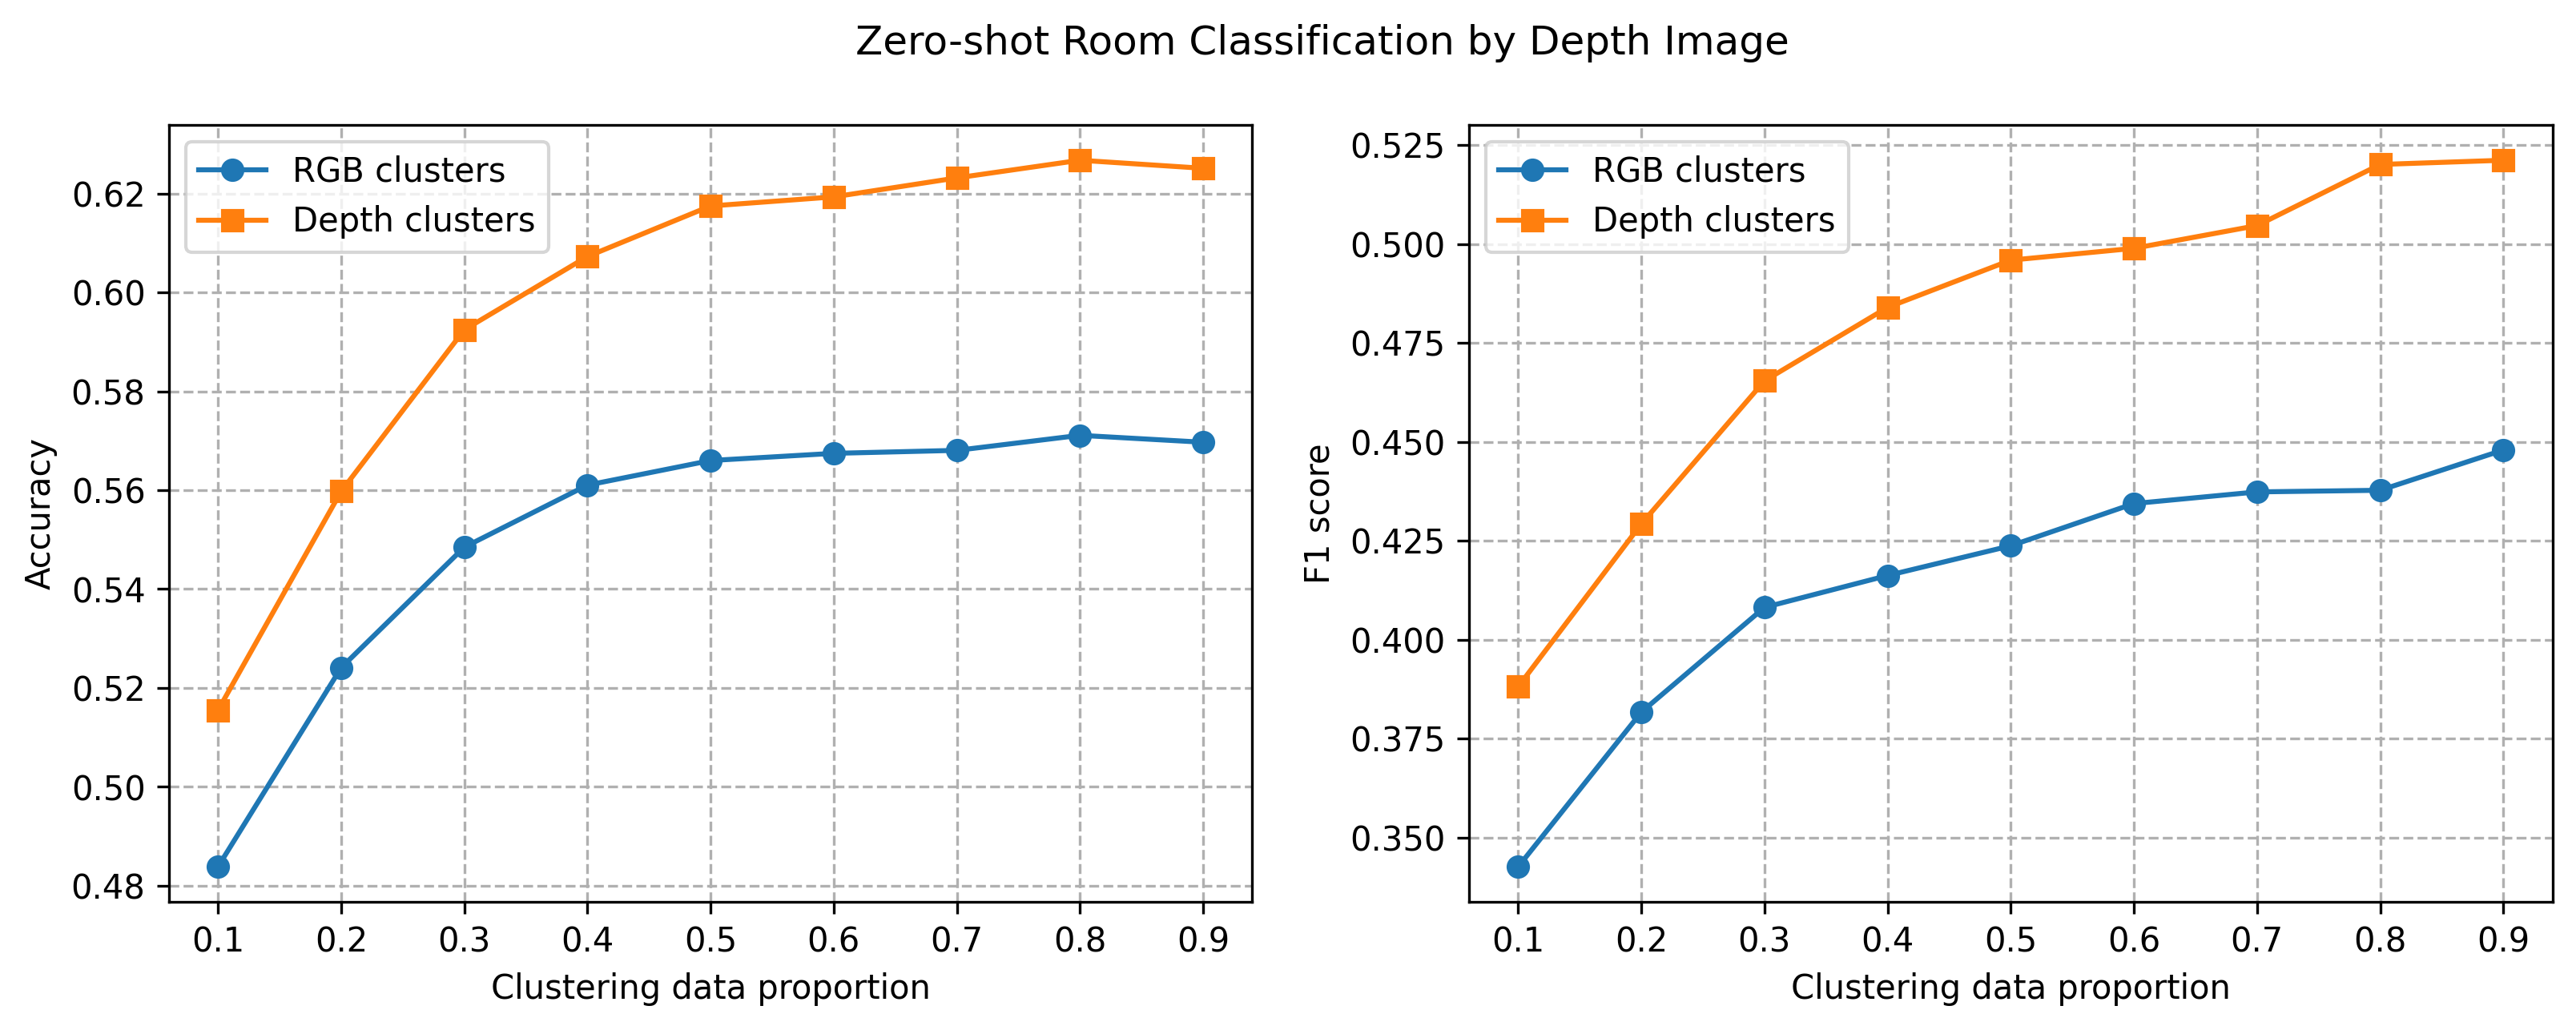

In [20]:
plt.figure(figsize=(12.8,4.2), dpi=300)
plt.subplot(1,2,1)
xrgb = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yrgb = [v["acc"] for k,v in results["rgb"].items()]
plt.plot(xrgb, yrgb, marker="o")
xdepth = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ydepth = [v["acc"] for k,v in results["depth"].items()]
plt.plot(xdepth, ydepth, marker="s")
plt.grid(visible=True, linewidth=0.8,linestyle='--')
# plt.ylim([0.3,0.6])
plt.xlabel("Clustering data proportion")
plt.ylabel("Accuracy")
plt.legend(["RGB clusters","Depth clusters"])
plt.subplot(1,2,2)
xrgb = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
yrgb = [v["f1"] for k,v in results["rgb"].items()]
plt.plot(xrgb, yrgb, marker="o")
xdepth = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ydepth = [v["f1"] for k,v in results["depth"].items()]
plt.plot(xdepth, ydepth, marker="s")
plt.grid(visible=True, linewidth=0.8,linestyle='--')
# plt.ylim([0.3,0.6])
plt.xlabel("Clustering data proportion")
plt.ylabel("F1 score")
plt.legend(["RGB clusters","Depth clusters"])
plt.suptitle("Zero-shot Room Classification by Depth Image")
plt.savefig("room.pdf", bbox_inches='tight')
plt.show()

In [271]:
main_labels = ['bathroom',
 'bedroom',
 'living room',
 'kitchen',
 'office',
 'hallway',
'hotel room',
 ]
few_labels = [

'dining room',
'classroom',
'playroom',
'conference room',
'break room',
'hotel',
'attic',
'basement',
'storage',
'hospital room',
'garage',
'waiting room',
'patio'
]
values = []
for lb in main_labels:
    values.append(cnt[lb])
values.append(0)
main_labels.append("others")
for lb in few_labels:
    values[-1] = values[-1]+cnt[lb]
values = np.array(values)
main_values = values/values.sum()
explode = np.zeros_like(main_values)
explode[-1] = 0.1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5),dpi=300)
fig.subplots_adjust(wspace=0)
angle = 180 * main_values[-1]
wedges, *_ = ax1.pie(main_values, autopct='%1.1f%%', startangle=angle,
                     labels=main_labels, explode=explode)

few_values = []
for lb in few_labels:
    few_values.append(cnt[lb])
few_values = np.array(few_values)
few_values = few_values/values.sum()
bottom = 1
width = .2

for j, (height, label) in enumerate(reversed([*zip(few_values, few_labels)])):
    print(height,label)
    bottom -= (height/np.sum(few_values))
    bc = ax2.bar(0, height/np.sum(few_values), width, bottom=bottom, color='#7f7f7f', label=label,
                 alpha=0.1 + 0.9/len(few_labels) * j)
    ax2.bar_label(bc, labels=[f"{height:.2%}"], label_type='center', fontsize="x-small")

# ax2.set_title('others')
ax2.legend(loc="right")
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 4.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[-1].theta1, wedges[-1].theta2
center, r = wedges[-1].center, wedges[-1].r
bar_height = 1
from matplotlib.patches import ConnectionPatch
# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

plt.show()

0.0021557749296422157 patio
0.0023255862113239273 waiting room
0.0025326731402040632 garage
0.0025968700881569056 hospital room
0.0037814073213512838 storage
0.003862171223614537 basement
0.004073399891072275 attic
0.004435802016612513 hotel
0.006461112181060244 break room
0.009768290435276016 conference room
0.012400365301342545 playroom
0.013464792115786444 classroom
0.02252070351571479 dining room


0.0021557749296422157 patio
0.0023255862113239273 waiting room
0.0025326731402040632 garage
0.0025968700881569056 hospital room
0.0037814073213512838 storage
0.003862171223614537 basement
0.004073399891072275 attic
0.004435802016612513 hotel
0.006461112181060244 break room
0.009768290435276016 conference room
0.012400365301342545 playroom
0.013464792115786444 classroom
0.02252070351571479 dining room


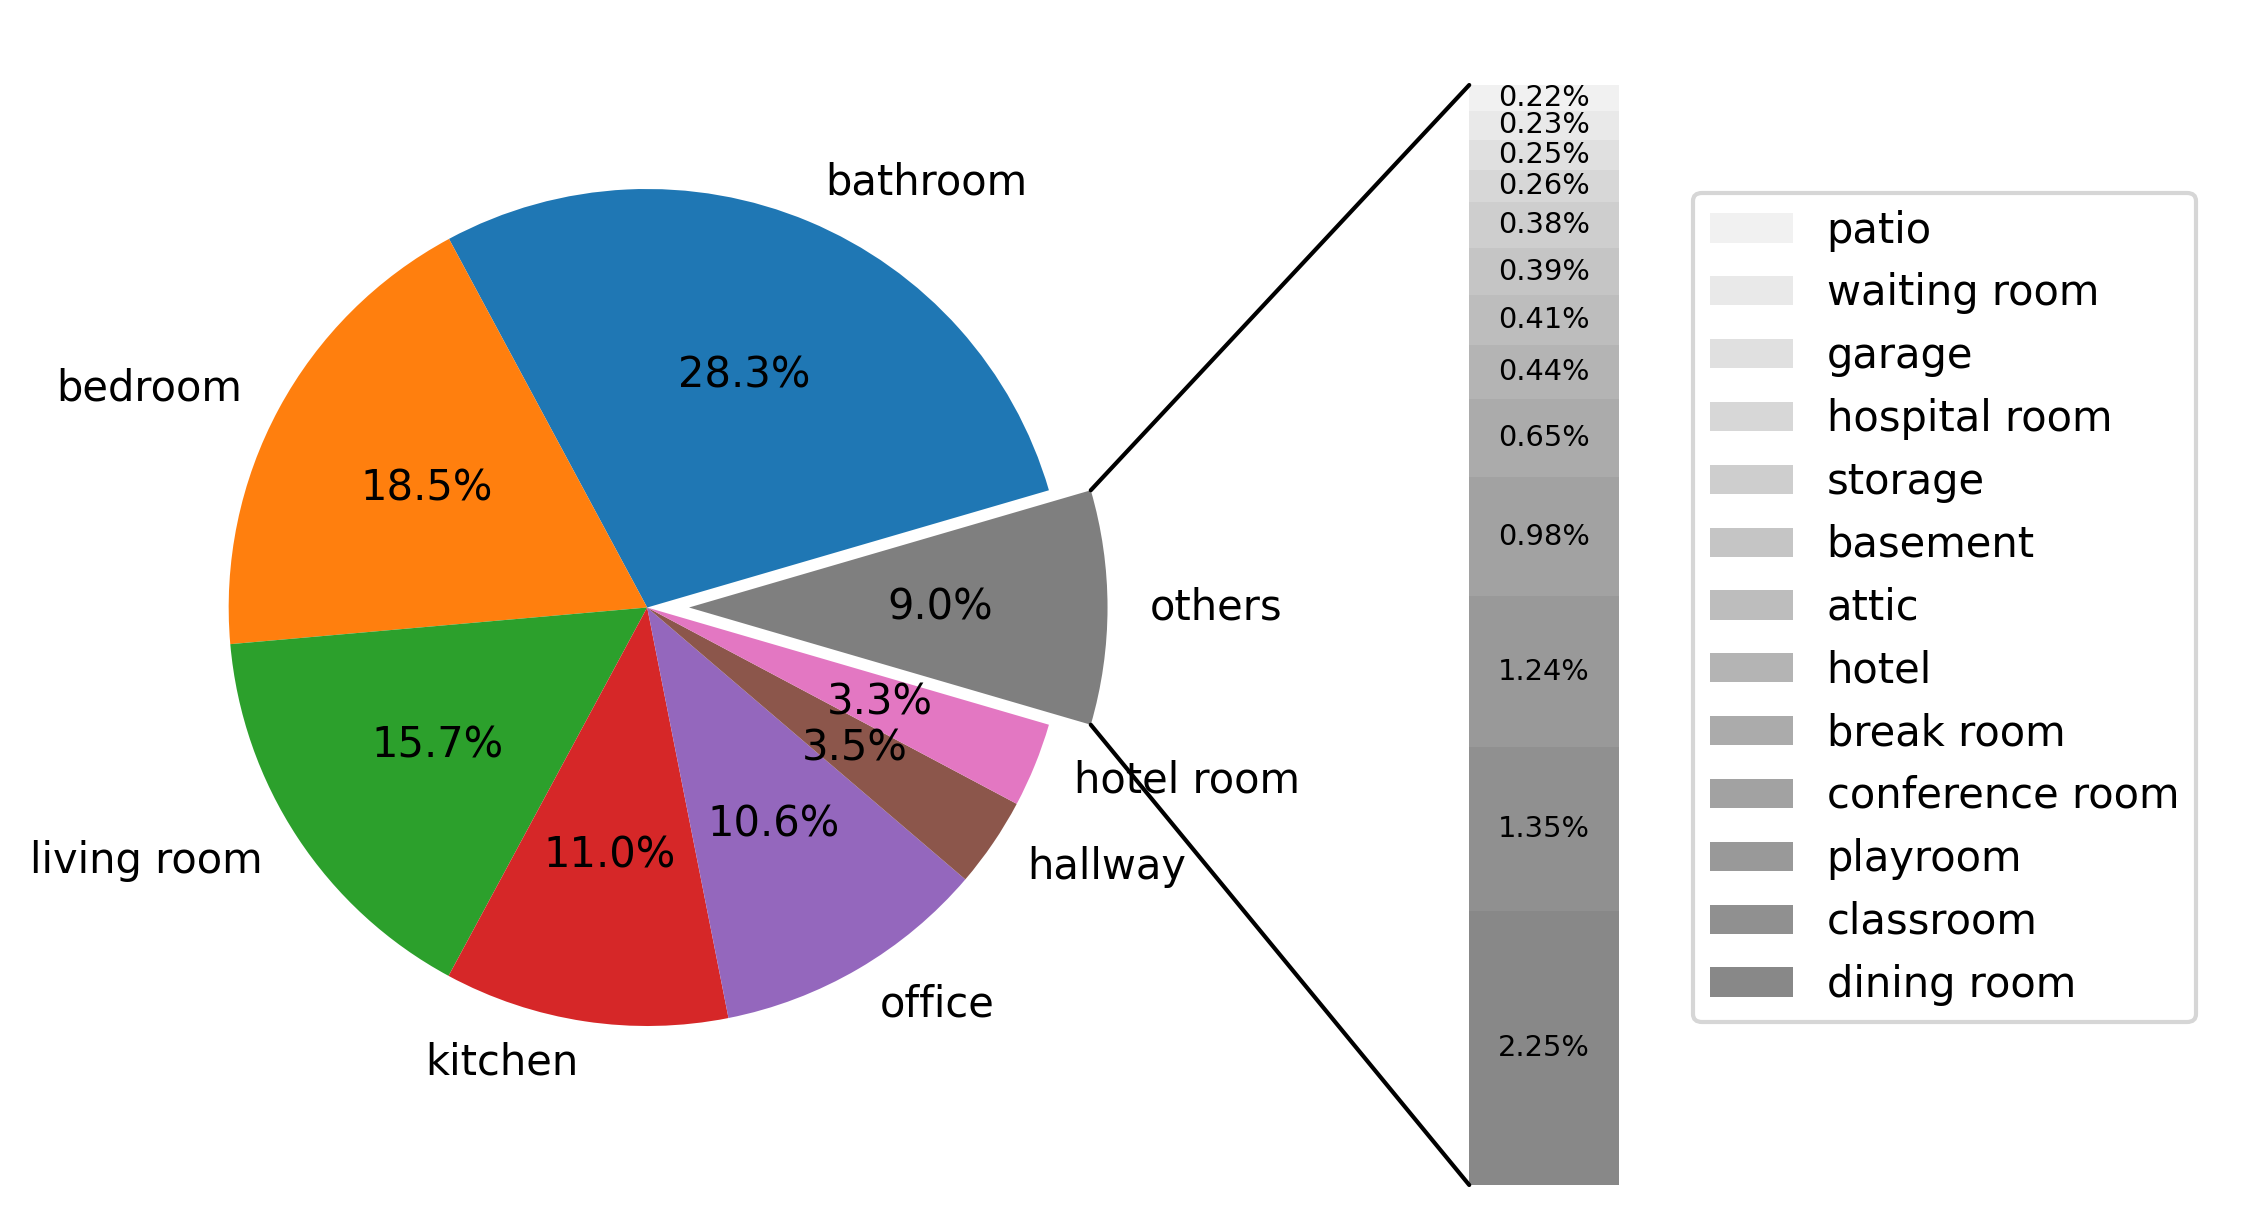

In [300]:
%matplotlib inline
plt.ion()
main_labels = ['bathroom',
 'bedroom',
 'living room',
 'kitchen',
 'office',
 'hallway',
'hotel room',
 ]
few_labels = [

'dining room',
'classroom',
'playroom',
'conference room',
'break room',
'hotel',
'attic',
'basement',
'storage',
'hospital room',
'garage',
'waiting room',
'patio'
]
values = []
for lb in main_labels:
    values.append(cnt[lb])
values.append(0)
main_labels.append("others")
for lb in few_labels:
    values[-1] = values[-1]+cnt[lb]
values = np.array(values)
main_values = values/values.sum()
explode = np.zeros_like(main_values)
explode[-1] = 0.1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5),dpi=300)
fig.subplots_adjust(wspace=0)
angle = 180 * main_values[-1]
wedges, pietexts, _ = ax1.pie(main_values, autopct='%1.1f%%', startangle=angle,
                     labels=main_labels, explode=explode)
few_values = []
for lb in few_labels:
    few_values.append(cnt[lb])
few_values = np.array(few_values)
few_values = few_values/values.sum()
bottom = 1
width = .2

for j, (height, label) in enumerate(reversed([*zip(few_values, few_labels)])):
    print(height,label)
    bottom -= (height/np.sum(few_values))
    bc = ax2.bar(0, height/np.sum(few_values), width, bottom=bottom, color='#7f7f7f', label=label,
                 alpha=0.1 + 0.9/len(few_labels) * j)
    ax2.bar_label(bc, labels=[f"{height:.2%}"], label_type='center', fontsize="x-small")

# ax2.set_title('others')
ax2.legend(loc="right")
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 4.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[-1].theta1, wedges[-1].theta2
center, r = wedges[-1].center, wedges[-1].r
bar_height = 1
from matplotlib.patches import ConnectionPatch
# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

# pietexts[-2].set_visible(False)
# tmp = ax1.text(pietexts[-2].get_position()[0], pietexts[-2].get_position()[1], pietexts[-2].get_text(), zorder=100)
# tmp.set_bbox(dict(facecolor='red',edgecolor='red'))
# pietexts[-2].set_zorder(10)
plt.savefig("room_composition.pdf", bbox_inches="tight")
plt.show()

In [13]:
train_portion = 0.8
key_type = "rgb"
print(key_type, train_portion)
result_rgb_08,pred,gt,rgb_files,depth_files = exp(train_portion=train_portion, key_type=key_type,return_pred=True)

rgb 0.8


In [23]:
success_idx =  np.array([pred[i]==gt[i] for i in range(len(pred))],dtype=bool)
fail_idx = np.logical_not(success_idx)

In [63]:
idx_set = []
room_type_contain = []
room_type_pred = []
randomlist = list(range(len(pred)))
np.random.shuffle(randomlist)
for i in randomlist:
    if "hallway" not in room_type_contain and gt[i]=="hallway" and success_idx[i]:
        idx_set.append(i)
        room_type_contain.append("hallway")
        room_type_pred.append(pred[i])
    if "waiting room" not in room_type_contain and gt[i]=="waiting room" and success_idx[i]:
        idx_set.append(i)
        room_type_contain.append("waiting room")
        room_type_pred.append(pred[i])
    if "patio" not in room_type_contain and gt[i]=="patio" and success_idx[i]:
        idx_set.append(i)
        room_type_contain.append("patio")
        room_type_pred.append(pred[i])
    if "bathroom" not in room_type_contain and gt[i]=="bathroom" and success_idx[i]:
        idx_set.append(i)
        room_type_contain.append("bathroom")
        room_type_pred.append(pred[i])
    if "kitchen" not in room_type_contain and gt[i]=="kitchen" and success_idx[i]:
        idx_set.append(i)
        room_type_contain.append("kitchen")
        room_type_pred.append(pred[i])
for i in randomlist:
    if "bedroom" not in room_type_contain and gt[i]=="bedroom" and fail_idx[i]:
        idx_set.append(i)
        room_type_contain.append("bedroom")
        room_type_pred.append(pred[i])
    if "basement" not in room_type_contain and gt[i]=="basement" and fail_idx[i]:
        idx_set.append(i)
        room_type_contain.append("basement")
        room_type_pred.append(pred[i])
    if "storage" not in room_type_contain and gt[i]=="storage" and fail_idx[i]:
        idx_set.append(i)
        room_type_contain.append("storage")
        room_type_pred.append(pred[i])

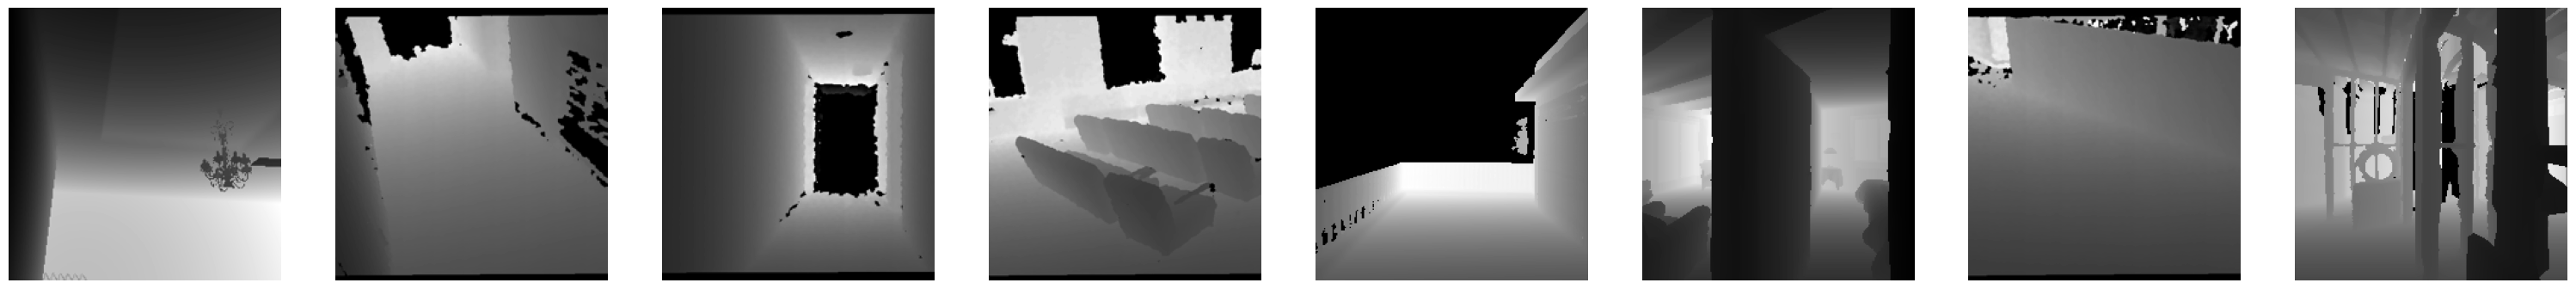

In [70]:
fig, axs = plt.subplots(nrows=1,ncols=8,figsize=(38.4,4.8))
for i in range(8):
    img = Image.open(depth_files[idx_set[i]])
    img = np.array(img).astype(float)
    axs[i].axis(False)
    axs[i].imshow(img,cmap="gray")
plt.savefig("visualization_zs.png",bbox_inches="tight")
plt.show()

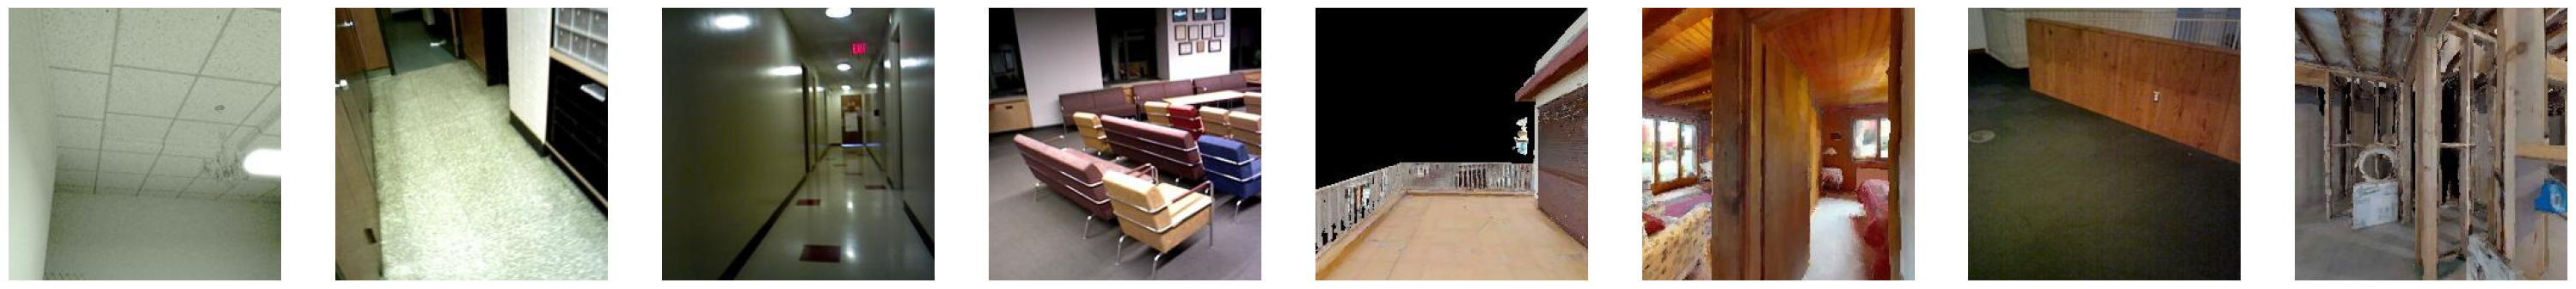

In [69]:
fig, axs = plt.subplots(nrows=1,ncols=8,figsize=(38.4,4.8))
for i in range(8):
    img = Image.open(rgb_files[idx_set[i]])
    # img = np.array(img).astype(float)
    axs[i].axis(False)
    axs[i].imshow(img)
plt.savefig("visualization_zs_rgb.png",bbox_inches="tight")
plt.show()

In [65]:
room_type_pred

['bathroom',
 'kitchen',
 'hallway',
 'waiting room',
 'patio',
 'hotel room',
 'kitchen',
 'bedroom']

In [72]:
room_type_contain

['bathroom',
 'kitchen',
 'hallway',
 'waiting room',
 'patio',
 'bedroom',
 'storage',
 'basement']